# Fitting Anisotropic Power Diagrams to Grain Maps

In [1]:
# relevant libraries
import PyAPD
from pykeops.torch import LazyTensor
import copy
import torch
import matplotlib.pyplot as plt

# typical setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


#### To check that the approach works, we will first create a small artificial 2D grain map using `PyAPD`:

Precision loss detected!
Percentage error =  92.97606658935547
Lloyds iteration: 0
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6760880351066589
Lloyds iteration: 1
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6760880351066589
Lloyds iteration: 2
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6760880351066589
Lloyds iteration: 3
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9362325072288513
Lloyds iteration: 4
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6760880351066589
Lloyds iteration: 5
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9362325072288513
Lloyds iteration: 6
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.6760880351066589
Lloyds iteration: 7
Optimality condition successfully o

(<Figure size 756x756 with 1 Axes>, <Axes: >)

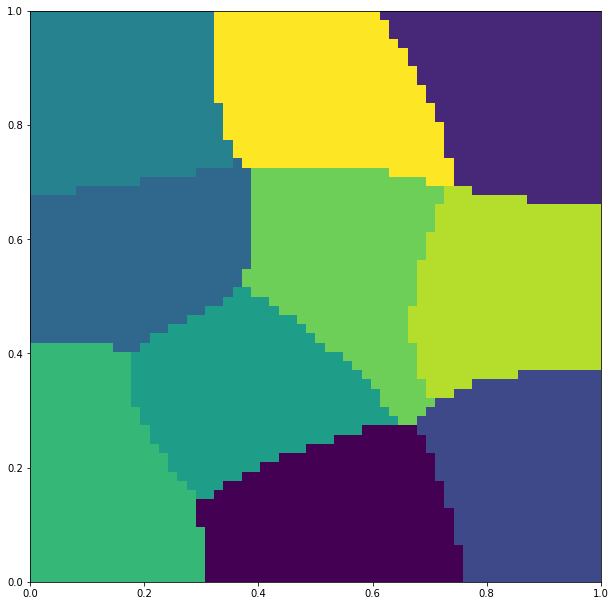

In [90]:
N = 10 # number of grains
apd1 = PyAPD.apd_system(
    N = N,
    seed = 5, # fix random seed
    pixel_size_prefactor = 2.0
)
apd1.check_optimality()
#apd1.find_optimal_W()
apd1.Lloyds_algorithm(K=10)
apd1.find_optimal_W()
apd1.plot_apd()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

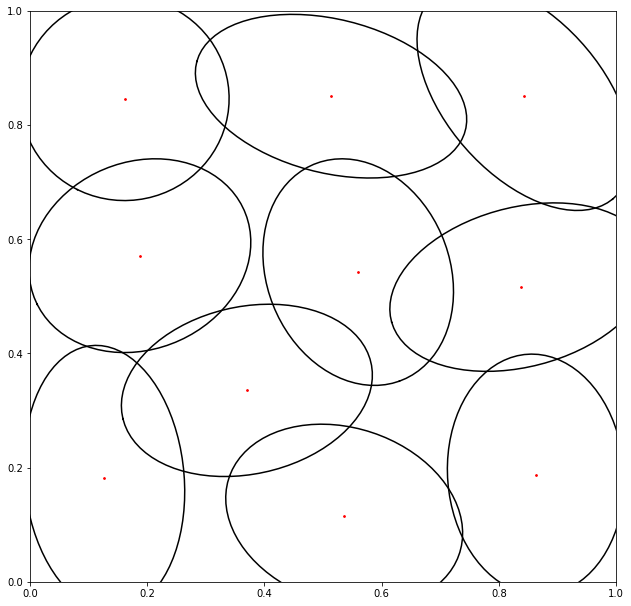

In [91]:
apd1.plot_ellipses()

In [92]:
# Save the data:
W_true = copy.deepcopy(apd1.W.contiguous())
As_true = copy.deepcopy(apd1.As.contiguous())
X_true = copy.deepcopy(apd1.X.contiguous())

# Save the grain map:
Y = copy.deepcopy(apd1.Y)
Y_t = Y.view(1, len(Y), 2)
II = copy.deepcopy(apd1.assemble_apd())
II = II + 1
y = LazyTensor(Y_t)
print("We have ", len(Y), " pixels and ", N, " grains.")

We have  3844  pixels and  10  grains.


In [93]:
torch.bincount(II-1)/apd1.Y.shape[0]

tensor([0.0999, 0.1004, 0.0996, 0.1004, 0.1002, 0.0991, 0.1009, 0.0999, 0.1004,
        0.0991])

## Reduced approach: fitting $W$

#### Equipped with the grain map, as a warm up let us try to use the approach to recover $W$. For this we do not need to rescale the variables, so we just proceed as follows:

In [172]:
eps = 1e-4 # regularisation parameter
gtol_scalar = 1e-6

In [95]:
def objective_function(X,A,W, use_torch = False, return_grad = False):
    dims = A.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(A,0,II-1), torch.index_select(X, 0, II-1) - Y)
    sD_ij = torch.einsum('bj,bj->b',MV,torch.index_select(X,0,II-1)-Y) - torch.index_select(W, 0, II-1)
    first_sum = (-sD_ij/eps).sum()
    
    W_t = W.view(dims[0],1,1)
    X_t = X.view(dims[0], 1, dims[1])
    second_sum = None
    second_part_torch = None
    if use_torch:
        MV_s = torch.einsum('bij,bkj->bki',A,Y_t-X_t)
        D_ij_torch = torch.einsum('bkj,bkj->bk',MV_s,Y_t-X_t)
        D_ij_torch = D_ij_torch = (D_ij_torch[:,:,None] - W_t)[:,:,0]
        second_sum = (-D_ij_torch/eps).logsumexp(dim=0).sum(dim=0)
        second_part_torch = (-D_ij_torch/eps).softmax(dim=0).sum(dim=1)/eps
    else:
        a = LazyTensor(A.view(dims[0], 1, dims[1] * dims[2]))
        w = LazyTensor(W_t)
        x = LazyTensor(X_t)
        D_ij = ((y - x) | a.matvecmult(y - x)) - w
        second_sum = (-D_ij/eps).logsumexp(dim=0).sum(dim=0)
    if return_grad:
        first_part = torch.bincount(II-1)/eps
        return -eps*(first_sum - second_sum), -eps*(first_part - second_part_torch)
    else:
        return -eps*(first_sum - second_sum)

# Defining the convex function to be optmised:
fun_red = lambda W : objective_function(X_true,As_true, W)
fun_red_torch_grad = lambda W : objective_function(X_true,As_true, W, use_torch = True, return_grad = True)

In [96]:
W_true_copy = copy.deepcopy(W_true)
W_true_copy.requires_grad = True
W_true_copy

tensor([-0.0032,  0.0013, -0.0100, -0.0023,  0.0013,  0.0067,  0.0009,  0.0031,
         0.0059, -0.0037], requires_grad=True)

In [97]:
f1 = fun_red(W_true_copy)
f1

tensor([0.0475], grad_fn=<MulBackward0>)

In [98]:
d_f1 = torch.autograd.grad(f1, W_true_copy, torch.ones_like(f1))[0]

In [99]:
d_f1

tensor([-0.1246,  1.5483, -0.6333, -1.6112, -0.9396, -0.0661, -0.8369,  5.3540,
        -0.0981, -2.5926])

In [100]:
f2, d_f2 = fun_red_torch_grad(W_true)

In [101]:
f2

tensor(0.0475)

In [102]:
d_f2

tensor([-0.1245,  1.5483, -0.6333, -1.6112, -0.9397, -0.0661, -0.8369,  5.3540,
        -0.0981, -2.5926])

In [103]:
# check agreement between 
f12 = torch.abs(f1 - f2) # torch and keops for values
df12 = torch.abs(d_f1-d_f2).max() # manual torch gradients and autodiff keops
print(f12, df12)

tensor([0.], grad_fn=<AbsBackward0>) tensor(0.0001)


In [104]:
gtol = gtol_scalar*torch.ones(N).to(device=device) # optimality condition (can be passed as vector!)

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':200,
                 'line_search': 'none',
                 #'lr': 1e-2,
                }

# solver = 'l-bfgs'
# defaultKwargs = {'gtol': gtol,
#                  'xtol': -1e-10,
#                  'disp': 3,
#                  'max_iter':100,
#                  #'line_search': 'none',
#                  #'lr': 1e-2,
#                 }

# solver = 'newton-cg'
# defaultKwargs = {#'gtol': gtol,
#                  'xtol': 1e-6,
#                  'disp': 3,
#                  'max_iter':1000,
#                  #'line_search': 'none',
#                  #'lr': 1e-2,
#                 }

res = PyAPD.minimize_torch(fun_red, torch.zeros(N), method=solver,
                             options=defaultKwargs)

W_approx = res.x

Optimality condition successfully overwritten.
initial fval: 0.6103
iter   1 - fval: 436.7343
iter   2 - fval: 0.5506
iter   3 - fval: 1.0207
iter   4 - fval: 0.0494
iter   5 - fval: 0.0454
iter   6 - fval: 0.0451
iter   7 - fval: 0.0449
iter   8 - fval: 0.0448
iter   9 - fval: 0.0448
iter  10 - fval: 0.0448
iter  11 - fval: 0.0448
iter  12 - fval: 0.0448
iter  13 - fval: 0.0448
iter  14 - fval: 0.0448
iter  15 - fval: 0.0448
iter  16 - fval: 0.0448
Optimization terminated successfully.
         Current function value: 0.044805
         Iterations: 16
         Function evaluations: 17


In [105]:
res.grad

tensor([ 3.0518e-05,  3.0518e-05,  3.0518e-05, -3.0518e-05, -3.0518e-05,
        -3.0518e-05,  0.0000e+00,  6.1035e-05, -3.0518e-05,  0.0000e+00])

In [106]:
W_approx.requires_grad = True

In [107]:
print(fun_red(W_approx))
print(fun_red(W_true_copy))

tensor([0.0448], grad_fn=<MulBackward0>)
tensor([0.0475], grad_fn=<MulBackward0>)


In [108]:
f1_approx = fun_red(W_approx)
f1_approx

tensor([0.0448], grad_fn=<MulBackward0>)

In [109]:
d_f1_approx = torch.autograd.grad(f1_approx, W_approx, torch.ones_like(f1_approx))[0]

In [110]:
d_f1_approx

tensor([ 3.0518e-05,  3.0518e-05,  3.0518e-05, -3.0518e-05, -3.0518e-05,
        -3.0518e-05,  0.0000e+00,  6.1035e-05, -3.0518e-05,  0.0000e+00])

In [111]:
f2_approx, d_f2_approx = fun_red_torch_grad(W_approx)

In [112]:
f2_approx

tensor(0.0448, grad_fn=<MulBackward0>)

In [113]:
d_f2_approx

tensor([ 3.1250e-05,  6.2500e-05,  3.1250e-05,  3.1250e-05, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -6.2500e-05, -3.1250e-05],
       grad_fn=<MulBackward0>)

In [114]:
# check agreement between 
f12 = torch.abs(f1_approx - f2_approx) # torch and keops for values
df12 = torch.abs(d_f1_approx-d_f2_approx).max() # manual torch gradients and autodiff keops
print(f12, df12)

tensor([0.], grad_fn=<AbsBackward0>) tensor(6.1768e-05, grad_fn=<MaxBackward1>)


Number of misassigned pixels:  tensor(7)
Proportion of misassigned pixels:  tensor(0.0018)


Text(0.5, 1.0, 'Misalligned pixels')

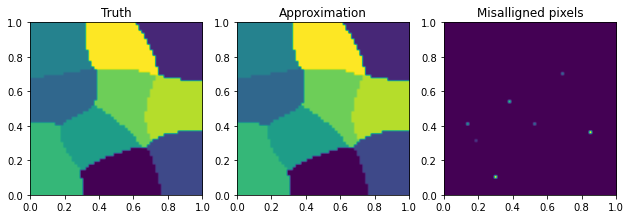

In [115]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_approx)
img_approx = copy.deepcopy(apd1.assemble_apd())

difff = sum(torch.abs(img_true - img_approx) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

apd1.set_W(W = W_true) # reset weights to the optimum

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

#### All seems to work pretty well!

## Full approach: Fitting $X$, $\Lambda$ and $W$ at the same time

#### First let us try a naive approach where we do not worry too much about the matrices $\mathbf{A}_i$ being positive definite, but only with them being symmetric. That way each matrix only gives three variables $a_{i,11}$, $a_{i,22}$ and $a_{i,12}$. We thus have a flat variable
$$
\theta = \{(x_{i,1}, x_{i,2}, a_{i,11}, a_{i,22}, a_{i,12}, w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$
#### and e.g. we can assemble the optimum that we know:

In [116]:
theta_true = torch.cat((X_true[:,0],X_true[:,1],As_true[:,0,0],As_true[:,1,1],As_true[:,0,1],W_true))
theta_true

tensor([ 5.3611e-01,  8.4343e-01,  8.6315e-01,  1.8746e-01,  1.6148e-01,
         3.7004e-01,  1.2661e-01,  5.6004e-01,  8.3718e-01,  5.1368e-01,
         1.1579e-01,  8.5074e-01,  1.8788e-01,  5.7136e-01,  8.4644e-01,
         3.3537e-01,  1.8131e-01,  5.4257e-01,  5.1628e-01,  8.5078e-01,
         8.0797e-01,  1.2595e+00,  1.3996e+00,  9.0563e-01,  1.0015e+00,
         7.1593e-01,  1.7043e+00,  1.2384e+00,  6.8453e-01,  6.4579e-01,
         1.2846e+00,  1.0525e+00,  7.1593e-01,  1.1260e+00,  9.9855e-01,
         1.4419e+00,  5.9276e-01,  8.3160e-01,  1.5650e+00,  1.6853e+00,
         1.9480e-01,  5.7063e-01,  4.4706e-02, -1.4045e-01, -1.9916e-03,
        -1.7970e-01,  1.0115e-01,  1.7282e-01, -2.6697e-01,  2.9721e-01,
        -3.2410e-03,  1.3447e-03, -9.9963e-03, -2.2595e-03,  1.3120e-03,
         6.6841e-03,  8.8689e-04,  3.1441e-03,  5.8675e-03, -3.6680e-03])

#### We can also introduce the rescaled variables 
$$
\tilde \theta = \{(\tilde x_{i,1}, \tilde x_{i,2}, \tilde a_{i,11}, \tilde a_{i,22}, \tilde a_{i,12}, \tilde w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$

In [117]:
def rescaling(X, As, W):
    At = As/eps
    Xt = 2.0*torch.einsum('bij,bj->bi', As, X)/eps
    Wt = (W - torch.einsum('bj,bj->b',X,eps*Xt/2.0))/eps
    return Xt, At, Wt

def inverse_rescaling(Xt, At, Wt):
    As = eps*At
    X = (eps/2.0)*torch.linalg.solve(As,Xt)
    MV = torch.einsum('bij,bj->bi', As, X)
    W = eps*Wt + torch.einsum('bj,bj->b',MV,X)
    return X, As, W

In [118]:
Xt_true, At_true, Wt_true = rescaling(X_true, As_true, W_true)
thetat_true = torch.cat((Xt_true[:,0],Xt_true[:,1],At_true[:,0,0],At_true[:,1,1],At_true[:,0,1],Wt_true))

#### And the new rescaled objective is

In [173]:
def objective_function_tilde(Xt,At,Wt, use_torch = False, return_grad = False):
    dims = At.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(At,0,II-1), Y)
    sD_ij = torch.einsum('bj,bj->b',MV,Y) - torch.index_select(Wt, 0, II-1) - torch.einsum('bi,bi->b',torch.index_select(Xt, 0, II-1),Y)
    first_sum = (-sD_ij).sum()

    Wt_t = Wt.view(dims[0],1,1)
    Xt_t = Xt.view(dims[0], 1, dims[1])
    second_sum = None
    #second_part_torch = None
    if use_torch:
        MV_s = torch.einsum('bij,bkj->bki',At,Y_t)
        D_ij_torch = torch.einsum('bkj,bkj->bk',MV_s,Y_t)
        D_ij_torch = ((D_ij_torch[:,:,None] - Wt_t) - torch.einsum('ijk,lik->lji',Y_t,Xt_t))[:,:,0]
        second_sum = (-D_ij_torch).logsumexp(dim=0).sum(dim=0)
    else:
        at = LazyTensor(At.view(dims[0], 1, dims[1] * dims[2]))
        wt = LazyTensor(Wt_t)
        xt = LazyTensor(Xt_t)
        D_ij =  (y | at.matvecmult(y)) - wt - ((y*xt).sum(dim=2))
        second_sum = (-D_ij).logsumexp(dim=0).sum(dim=0)
    return -eps*(first_sum - second_sum)

#### We also want have the ability to go from flat variables to shaped variables quickly, so here are some helper functions:

In [174]:
def As_from_scalars(a11,a22,a12):
    return torch.stack([torch.stack([a11, a12],dim=1),
                            torch.stack([a12, a22], dim=1)],dim=2)

def X_from_scalar(x1,x2):
    return torch.stack([x1,x2],dim=1)

def from_theta_to_X_A_W(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    a11 = theta[(2*N):(3*N)]
    a22 = theta[(3*N):(4*N)]
    a12 = theta[(4*N):(5*N)]
    Wt = theta[(5*N):(6*N)]
    At = As_from_scalars(a11,a22,a12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [121]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W(thetat_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W(theta_true)
print(torch.dist(As_test,As_true))

tensor(9.8962e-08)
tensor(9.6642e-08)


In [122]:
# Defining the convex function to be optmised:
def fun(thetat):
    Xt, At, Wt = from_theta_to_X_A_W(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [123]:
# Defining the convex function to be optmised:
def fun_torch(thetat):
    Xt, At, Wt = from_theta_to_X_A_W(thetat)
    return objective_function_tilde(Xt,At,Wt, use_torch=True)

In [124]:
# Sanity check
print(fun(thetat_true),fun_red(W_true))

tensor([0.0475]) tensor([0.0475])


In [125]:
thetat_true.requires_grad = True

In [126]:
f1 = fun(thetat_true)
f1

tensor([0.0475], grad_fn=<MulBackward0>)

In [127]:
d_f1 = torch.autograd.grad(f1, thetat_true, torch.ones_like(f1))[0]

In [128]:
d_f1

tensor([ 4.3446e-04,  1.0775e-03, -4.8721e-04, -8.6296e-04, -1.6855e-04,
        -6.0083e-04, -7.8537e-05,  2.4445e-03, -5.6237e-05, -1.7012e-03,
         8.0083e-05,  1.2313e-03, -9.7163e-05, -1.2477e-03, -8.6951e-04,
        -1.9330e-04, -4.1021e-04,  3.4106e-03, -7.3969e-05, -1.8291e-03,
        -4.6357e-04, -7.5093e-04,  3.7920e-04,  3.3991e-04,  4.7110e-05,
         5.0280e-04, -1.0049e-06, -1.1343e-03,  2.0742e-05,  1.0585e-03,
        -4.3995e-05, -1.0008e-03,  2.0659e-05,  9.1626e-04,  8.1143e-04,
         8.5983e-05,  1.7454e-04, -2.2925e-03,  5.3398e-05,  1.2752e-03,
        -2.4725e-04, -1.6943e-03,  1.5556e-04,  1.2202e-03,  3.7092e-04,
         4.9954e-04,  1.0850e-04, -3.0389e-03,  1.0195e-04,  2.5234e-03,
        -1.2326e-04,  1.5503e-03, -6.3166e-04, -1.6101e-03, -9.3800e-04,
        -6.4522e-05, -8.3548e-04,  5.3557e-03, -9.7334e-05, -2.5914e-03])

In [129]:
f2 = fun_torch(thetat_true)
f2

tensor(0.0475, grad_fn=<MulBackward0>)

In [130]:
d_f2 = torch.autograd.grad(f2, thetat_true, torch.ones_like(f2))[0]

In [131]:
d_f2

tensor([ 4.3449e-04,  1.0775e-03, -4.8721e-04, -8.6295e-04, -1.6852e-04,
        -6.0087e-04, -7.8544e-05,  2.4446e-03, -5.6356e-05, -1.7011e-03,
         8.0097e-05,  1.2313e-03, -9.7170e-05, -1.2476e-03, -8.6951e-04,
        -1.9334e-04, -4.1022e-04,  3.4106e-03, -7.4044e-05, -1.8290e-03,
        -4.6358e-04, -7.5093e-04,  3.7923e-04,  3.3992e-04,  4.7102e-05,
         5.0282e-04, -1.0058e-06, -1.1344e-03,  2.0802e-05,  1.0584e-03,
        -4.3998e-05, -1.0006e-03,  2.0659e-05,  9.1620e-04,  8.1146e-04,
         8.5998e-05,  1.7454e-04, -2.2925e-03,  5.3443e-05,  1.2750e-03,
        -2.4726e-04, -1.6941e-03,  1.5557e-04,  1.2202e-03,  3.7087e-04,
         4.9956e-04,  1.0850e-04, -3.0390e-03,  1.0212e-04,  2.5231e-03,
        -1.2323e-04,  1.5502e-03, -6.3166e-04, -1.6100e-03, -9.3809e-04,
        -6.4641e-05, -8.3542e-04,  5.3557e-03, -9.7424e-05, -2.5912e-03])

In [132]:
# check agreement between 
f12 = torch.abs(f1 - f2) # torch and keops for values
df12 = torch.abs(d_f1-d_f2).max() # autodiff torch vs keops
print(f12, df12)

tensor([2.3440e-05], grad_fn=<AbsBackward0>) tensor(2.3842e-07)


In [ ]:
# initial guess based on moments!

In [175]:
II_new = II - 1
normalisation = torch.bincount(II_new)
vols = normalisation / apd1.Y.shape[0]

X0 = torch.bincount(II_new,apd1.Y[:,0],minlength=apd1.N)/normalisation
X1 = torch.bincount(II_new,apd1.Y[:,1],minlength=apd1.N)/normalisation
XX = torch.stack([X0,X1]).permute(1,0)

i = 0
YY_XX_new = apd1.Y[II_new==i] - XX[i]
tensor_prod = torch.einsum('bc,bd->bcd', YY_XX_new, YY_XX_new)
tensor_prod_normalised = 16.0*tensor_prod.sum(dim=0) / normalisation[i]
A_best = torch.linalg.inv(tensor_prod_normalised)
As_best = A_best[None,:,:]

for i in range(1,apd1.N):
    YY_XX_new = apd1.Y[II_new==i] - XX[i]
    tensor_prod = torch.einsum('bc,bd->bcd', YY_XX_new, YY_XX_new)
    tensor_prod_normalised = 16.0*tensor_prod.sum(dim=0) / normalisation[i]
    A_best = torch.linalg.inv(tensor_prod_normalised)
    As_best = torch.cat((As_best,A_best[None,:,:]),dim=0)

In [176]:
apd2 = PyAPD.apd_system(D = 2,
                        N=apd1.N,
                        X = XX.contiguous(),
                        As = As_best.contiguous(),
                        target_masses = vols.contiguous(),
                        heuristic_W=True,
                        pixel_size_prefactor= 2)

(<Figure size 756x756 with 1 Axes>, <Axes: >)

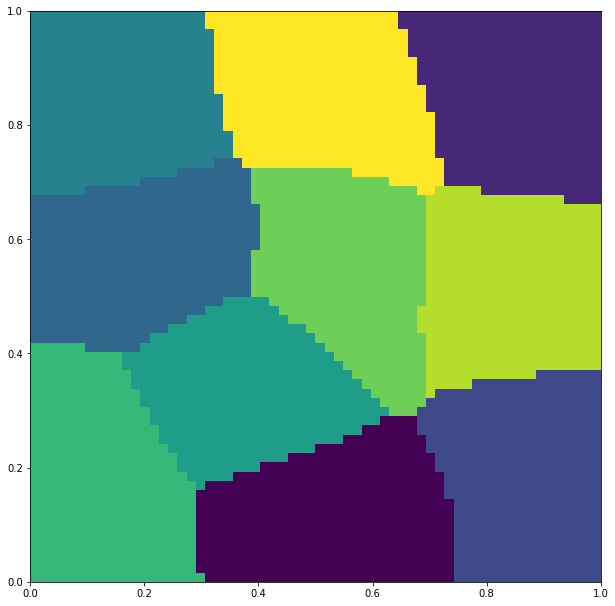

In [178]:
apd2.plot_apd()

In [179]:
theta_initial = torch.cat((apd2.X[:,0],apd2.X[:,1],apd2.As[:,0,0],apd2.As[:,1,1],apd2.As[:,0,1],apd2.W))
theta_initial

tensor([ 0.5355,  0.8464,  0.8631,  0.1876,  0.1615,  0.3766,  0.1265,  0.5558,
         0.8344,  0.5157,  0.1158,  0.8480,  0.1873,  0.5711,  0.8464,  0.3328,
         0.1830,  0.5531,  0.5099,  0.8533,  4.4063,  7.6969,  9.4939,  5.8692,
         6.8090,  5.5381, 11.2017,  9.0709,  7.4709,  5.8338, 12.6641,  7.3621,
         6.0014, 10.6665,  8.1430, 10.1586,  5.0649,  5.6077,  7.5784, 10.7055,
        -0.9156,  1.9442,  0.4709, -2.2990, -0.2695, -0.0976,  2.4267,  2.0561,
        -0.8114,  2.3348,  0.2357,  0.2324,  0.2389,  0.2420,  0.2372,  0.2366,
         0.2291,  0.2172,  0.2391,  0.2382])

In [180]:
Xt_initial, At_initial, Wt_initial = rescaling(apd2.X, apd2.As, apd2.W)
thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],At_initial[:,0,0],At_initial[:,1,1],At_initial[:,0,1],Wt_initial))

In [181]:
gtol = gtol_scalar*torch.ones(6*N).to(device=device)
# Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
#                                                dim=2,
#                                                radius_prefactor = apd1.radius_of_exclusion,
#                                                verbose = False).to(device=apd1.device, dtype=apd1.dt)

fun(thetat_initial)

tensor([3.3180])

In [182]:
gtol_scalar

1e-06

In [183]:
fun(thetat_true)

tensor([0.0047], grad_fn=<MulBackward0>)

In [185]:
#solver = 'bfgs'
#defaultKwargs = {'gtol': gtol, 'xtol': 0.0, 'disp': 2, 'max_iter':10000}

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':1000,
                 'line_search': 'none',
                 #'lr': 1e-1,
                }

# solver = 'newton-cg'
# defaultKwargs = {#'gtol': gtol,
#                  #'xtol': -1e-10,
#                  'disp': 3,
#                  'max_iter':500,
#                  #'line_search': 'none',
#                  #'lr': 1e-2,
#                 }

# solver='cg'
# defaultKwargs = {'gtol': 1e-3,
#                  #'xtol': 1e-10,
#                  'disp': 3,
#                  'max_iter':1000,
#                  #'line_search': 'none',
#                  #'lr': 1e-2,
#                 }

res = PyAPD.minimize_torch(fun_torch, thetat_initial, method=solver,
                             options=defaultKwargs)

thetat_approx = res.x

Optimality condition successfully overwritten.
initial fval: 3.3181
iter   1 - fval: 3.3181
iter   2 - fval: 3.3181
iter   3 - fval: 3.3180
iter   4 - fval: 3.3180
iter   5 - fval: 3.3180
iter   6 - fval: 3.3180
iter   7 - fval: 3.3180
iter   8 - fval: 3.3181
iter   9 - fval: 3.3180
iter  10 - fval: 3.3181
iter  11 - fval: 3.3180
iter  12 - fval: 3.3180
iter  13 - fval: 3.3180
iter  14 - fval: 3.3180
iter  15 - fval: 3.3180
iter  16 - fval: 3.3180
iter  17 - fval: 3.3180
iter  18 - fval: 3.3180
iter  19 - fval: 3.3180
iter  20 - fval: 3.3180
iter  21 - fval: 3.3180
iter  22 - fval: 3.3179
iter  23 - fval: 3.3179
iter  24 - fval: 3.3179
iter  25 - fval: 3.3179
iter  26 - fval: 3.3178
iter  27 - fval: 3.3180
iter  28 - fval: 3.3179
iter  29 - fval: 3.3179
iter  30 - fval: 3.3178
iter  31 - fval: 3.3178
iter  32 - fval: 3.3178
iter  33 - fval: 3.3179
iter  34 - fval: 3.3177
iter  35 - fval: 3.3178
iter  36 - fval: 3.3178
iter  37 - fval: 3.3177
iter  38 - fval: 3.3177
iter  39 - fval: 3.3

In [186]:
res.grad.max()

tensor(9.3319e-05)

In [187]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [188]:
thetat_approx.requires_grad = True

In [189]:
print(fun(thetat_approx))
print(fun(thetat_true))

tensor([0.0034], grad_fn=<MulBackward0>)
tensor([0.0047], grad_fn=<MulBackward0>)


In [190]:
f1_approx = fun(thetat_approx)
f1_approx

tensor([0.0034], grad_fn=<MulBackward0>)

In [191]:
d_f1_approx = torch.autograd.grad(f1_approx, thetat_approx, torch.ones_like(f1_approx))[0]

In [192]:
d_f1_approx

tensor([ 1.3229e-05, -3.9320e-05, -2.5854e-06, -1.6200e-06, -2.1746e-07,
        -3.7327e-06,  9.3784e-07, -3.7396e-05,  5.0217e-06,  6.5587e-05,
         6.3237e-06, -4.1548e-05,  6.1467e-08, -1.7956e-06,  4.4331e-07,
        -2.4317e-06,  6.0210e-07, -3.4494e-05,  3.0715e-06,  6.9760e-05,
        -5.9269e-06,  2.9452e-05,  1.9800e-06, -2.0524e-07,  1.3632e-07,
         3.9581e-08, -1.0809e-07,  2.6346e-05, -5.0422e-06, -4.6649e-05,
        -9.8639e-07,  3.2950e-05, -4.3656e-08,  1.3802e-06, -2.3097e-07,
        -8.9128e-07,  1.5215e-07,  2.2916e-05, -2.5686e-06, -5.2599e-05,
        -4.3688e-06,  6.0942e-05, -4.6566e-08,  9.4436e-07,  3.3528e-07,
         7.6741e-07, -5.6467e-07,  4.6491e-05, -6.6683e-06, -9.7815e-05,
         3.2783e-05, -5.3175e-05, -3.0659e-06, -2.9877e-06,  5.8487e-07,
        -2.0988e-05,  4.1611e-06, -5.5581e-05,  4.0494e-06,  9.3333e-05])

In [193]:
f2_approx = fun_torch(thetat_approx)
f2_approx

tensor(0.0035, grad_fn=<MulBackward0>)

In [194]:
d_f2_approx = torch.autograd.grad(f2_approx, thetat_approx, torch.ones_like(f2_approx))[0]

In [195]:
d_f2_approx

tensor([ 1.3219e-05, -3.9335e-05, -2.6152e-06, -1.5912e-06, -2.1048e-07,
        -3.7597e-06,  9.3784e-07, -3.7272e-05,  4.9882e-06,  6.5552e-05,
         6.3214e-06, -4.1500e-05,  4.6100e-08, -1.7863e-06,  4.6939e-07,
        -2.4624e-06,  6.0210e-07, -3.4442e-05,  3.0622e-06,  6.9711e-05,
        -5.9251e-06,  2.9473e-05,  1.9949e-06, -2.1793e-07,  1.3504e-07,
         5.3551e-08, -1.0809e-07,  2.6247e-05, -5.0273e-06, -4.6619e-05,
        -9.8598e-07,  3.2883e-05, -3.8533e-08,  1.3914e-06, -2.5705e-07,
        -8.7451e-07,  1.5181e-07,  2.2899e-05, -2.5751e-06, -5.2540e-05,
        -4.3670e-06,  6.0916e-05, -2.8871e-08,  9.2667e-07,  3.2503e-07,
         7.9535e-07, -5.6467e-07,  4.6385e-05, -6.6645e-06, -9.7722e-05,
         3.2768e-05, -5.3160e-05, -3.1069e-06, -2.9318e-06,  6.4448e-07,
        -2.1026e-05,  4.1761e-06, -5.5447e-05,  3.9898e-06,  9.3319e-05])

In [196]:
# check agreement between 
f12 = torch.abs(f1_approx - f2_approx) # torch and keops for values
df12 = torch.abs(d_f1_approx-d_f2_approx).max() # manual torch gradients and autodiff keops
print(f12, df12)

tensor([5.0000e-05], grad_fn=<AbsBackward0>) tensor(1.3411e-07)


In [197]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(), As = As_approx.contiguous(), W = W_approx2.contiguous())

Number of misassigned pixels:  tensor(5)
Proportion of misassigned pixels:  tensor(0.0013)


Text(0.5, 1.0, 'Misalligned pixels')

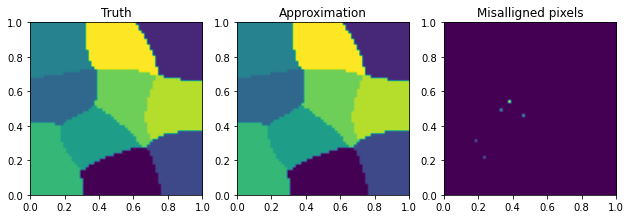

In [198]:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

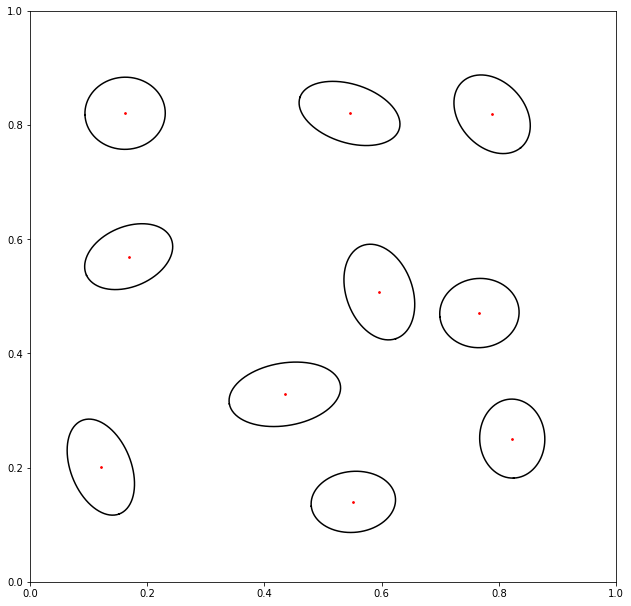

In [199]:
apd2.plot_ellipses()

In [200]:
torch.linalg.det(apd2.As)

tensor([68.1877, 54.9667, 68.3982, 59.3864, 53.9469, 36.5336, 49.2971, 42.2956,
        60.0155, 48.6407])

#### Not caring about positive definiteness of the matrices seems to affect things, which can be seen e.g. by restarting the optimisation procedure at a better initial guess:

In [201]:
print("The found optimum: ", fun(res.x))
print("The known actually optimum: ", fun(thetat_true))

The found optimum:  tensor([0.0034], grad_fn=<MulBackward0>)
The known actually optimum:  tensor([0.0047], grad_fn=<MulBackward0>)


In [202]:
res2 = PyAPD.minimize_torch(fun, thetat_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 0.0047
iter   1 - fval: 0.0047
iter   2 - fval: 0.0045
iter   3 - fval: 0.0045
iter   4 - fval: 0.0044
iter   5 - fval: 0.0044
iter   6 - fval: 0.0044
iter   7 - fval: 0.0044
iter   8 - fval: 0.0043
iter   9 - fval: 0.0043
iter  10 - fval: 0.0043
iter  11 - fval: 0.0042
iter  12 - fval: 0.0042
iter  13 - fval: 0.0042
iter  14 - fval: 0.0042
iter  15 - fval: 0.0041
iter  16 - fval: 0.0041
iter  17 - fval: 0.0041
iter  18 - fval: 0.0041
iter  19 - fval: 0.0041
iter  20 - fval: 0.0041
iter  21 - fval: 0.0041
iter  22 - fval: 0.0041
iter  23 - fval: 0.0041
iter  24 - fval: 0.0041
iter  25 - fval: 0.0041
iter  26 - fval: 0.0041
iter  27 - fval: 0.0041
iter  28 - fval: 0.0040
iter  29 - fval: 0.0040
iter  30 - fval: 0.0040
iter  31 - fval: 0.0040
iter  32 - fval: 0.0040
iter  33 - fval: 0.0040
iter  34 - fval: 0.0040
iter  35 - fval: 0.0040
iter  36 - fval: 0.0040
iter  37 - fval: 0.0039
iter  38 - fval: 0.0039
iter  39 - fval: 0.0

In [203]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [204]:
torch.linalg.det(As_approx)

tensor([68.1877, 54.9667, 68.3982, 59.3864, 53.9469, 36.5336, 49.2971, 42.2956,
        60.0155, 48.6407], grad_fn=<LinalgDetBackward0>)

In [205]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(), As = As_approx.contiguous(), W = W_approx2.contiguous())

Number of misassigned pixels:  tensor(5)
Proportion of misassigned pixels:  tensor(0.0013)


Text(0.5, 1.0, 'Misalligned pixels')

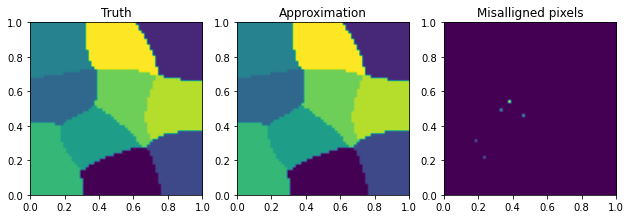

In [206]:
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')